In [1]:
from math import exp
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.utils.data import Dataset, DataLoader
from torch.nn import functional as F
from torch import nn, optim

In [2]:
# initialize parameters
global k, beta
k, beta = .01 , 500

In [3]:
def f(x):
    return -(2*exp(-(x - 1/3)**2/k)*(6*k + 2*x - 27*k*x - 12*x**2 + 18*x**3))/(9*k**2)
  
def g(x):
    return torch.tensor([0.], requires_grad=True)

def u_exact(x):
    return x*(exp(-1/k*(x-1/3)**2) - exp(-4/(9*k)))

def sigma_exact(x):
    return exp(-4/(9*k)) - exp(-(x - 1/3)**2/k) + (x*exp(-(x - 1/3)**2/k)*(2*x - 2/3))/k
  
sq = lambda x: x ** 2
vsq = np.vectorize(sq)

In [4]:
# compute H1 norm of u and sigma
L = 0.
R = 1.
h_test = 0.002
dx_test = 0.002
test_set =  np.arange(L, R+h_test, h_test)
u = np.vectorize(u_exact)(test_set)
ud = -np.vectorize(sigma_exact)(test_set)
u_h1 = np.sum(dx_test*(vsq(u) + vsq(ud)))
u_l2 = np.sum(dx_test*vsq(u))

sigma = np.vectorize(sigma_exact)(test_set)
sigmad = np.vectorize(f)(test_set)
sigma_h1 = np.sum(dx_test*(vsq(sigma) + vsq(sigmad)))
sigma_l2 = np.sum(dx_test*vsq(sigma))

print('u: H1 norm square: %.6f, L2 norm square: %.6f ' %(u_h1, u_l2))
print('sigma: H1 norm square: %.6f, L2 norm square: %.6f ' %(sigma_h1, sigma_l2))

u: H1 norm square: 1.500809, L2 norm square: 0.014239 
sigma: H1 norm square: 466.257229, L2 norm square: 1.486570 


In [5]:
class MuSigmaPde(nn.Module):
    def __init__(self, dimension, mesh = 24, neuron = 14):
        super(MuSigmaPde, self).__init__()

        self.xdim = dimension
        # Layer 1
        self.fc1mu = nn.Linear(dimension, mesh)
        self.fc1sig = nn.Linear(dimension, mesh)
        # Layer 2
        self.fc2mu = nn.Linear(mesh, neuron)
        self.fc2sig = nn.Linear(mesh, neuron)
        # Layer 3
        self.fc3mu = nn.Linear(neuron, neuron)
        self.fc3sig = nn.Linear(neuron, neuron)
        # Layer 4
        self.fc4mu = nn.Linear(neuron, 1)
        self.fc4sig = nn.Linear(neuron, dimension)

    def forward(self, x):
        assert(len(x.shape) == 1 and x.shape[0] == self.xdim)
        mu =  F.leaky_relu(self.fc2mu(F.leaky_relu(self.fc1mu(x))))
        sig =  F.leaky_relu(self.fc2sig(F.leaky_relu(self.fc1sig(x))))
        mu =  self.fc4mu(F.leaky_relu(self.fc3mu(mu)) + mu)
        sig = self.fc4sig(F.leaky_relu(self.fc3sig(sig)) + sig)
        return mu, sig
      
    def net_grad(self, x, dx):
        mu_center, sigma_center = self.forward(x)
        mu_forward, sigma_forward = self.forward(x - dx)
        mu_grad_forward = (mu_center - mu_forward)/(dx)
        sigma_grad_forward = (sigma_center - sigma_forward)/(dx)
        return mu_grad_forward, sigma_grad_forward
    
    def loss_function_bulk(self, x, dx):
        mu, sigma = self.forward(x)
        mu_grad, sigma_grad = self.net_grad(x, dx)
        LSE = torch.sum((mu_grad + sigma)**2) + (sigma_grad - f(x))**2
        return LSE 

    def loss_function_surf(self, x):
        mu, sigma = self.forward(x)
        # Boundary condition penalty
        BCP = beta * (mu - g(x))**2
        return BCP

In [6]:
def find_index(loss_set):
    theta = 0.2
    total_loss = np.sum(loss_set)
    index = np.cumsum(-np.sort(-loss_set)) > theta*total_loss    
    n = len(index)
    for i in range(n):
        if index[i] == True:
            return i+1
    return n

def mesh_refine(points):    #adaptive refinement
    loss_set = np.zeros(points.shape)
    for i in range(points.shape[0]-1):
        h = points[i+1] - points[i]
        x = torch.tensor([points[i] + 0.5*h])
        loss_set[i] = h*model.loss_function_bulk(x, 0.5*h)
        
    # last interval    
    h_final = 1. - bulk_set[-1]  
    x_final = torch.tensor([bulk_set[-1] + 0.5*h_final])
    loss_set[-1] = h_final * model.loss_function_bulk(x_final, 0.5*h_final)
    

    loss_set_sort_index = np.argsort(-loss_set)
    #n = find_index(loss_set)
    n1 = int(len(loss_set_sort_index)/10)     #top 10% intervals are being bisected
    points_refine_index = loss_set_sort_index[0:n1]
    points_refine_number = len(points_refine_index)
    num_add = 3
    print(points_refine_index)
    new_points = points
    for i in range(points_refine_number):
        points_append = np.linspace(points[points_refine_index[i]-1], points[points_refine_index[i]], num_add)
        new_points = np.append(new_points, points_append[1::])
    points = np.unique(new_points)
    points.sort()
    return points

In [7]:
model = MuSigmaPde(dimension =1, mesh = 24, neuron = 14)
sum([p.numel() for p in model.parameters()])

1246

In [ ]:
h = .005   #statring uniform partition size
epochs = 2000
L, R = 0., 1.
bulk_set, surf_set =  np.arange(L, R, h), [L, R]
loss_bulk_record, loss_surf_record = [], []
print('bulk points number %d \nsurface points number %d\ntest points number %d\ndx for difference %.3g\ntrainging iteration %d' %(np.size(bulk_set), np.size(surf_set), np.size(test_set), dx_test, epochs))

In [9]:
optimizer = optim.Adam(model.parameters(), lr = 0.0005)

In [ ]:
# same initilization with uniform refinement.
# load the model with 2000 iterations on 200 uniform points and then refine adaptively
model.load_state_dict(torch.load('./poisson_equation_leaky_uniform_200pts'))
bulk_set = mesh_refine(bulk_set)

In [ ]:
local_min = 100.0
print(bulk_set.size)
for j in range(epochs):
    loss_bulk = torch.zeros(1)
    loss_surf = torch.zeros(1)
    for i in range(bulk_set.shape[0]):
        if i >= 1:
            h = bulk_set[i] - bulk_set[i-1]
            x = torch.tensor([bulk_set[i-1] + 0.5*h])
            loss_bulk += h*model.loss_function_bulk(x, 0.5*h)
    h_final = 1. - bulk_set[-1]
    x_final = torch.tensor([bulk_set[-1] + 0.5*h_final])
    loss_bulk += h_final * model.loss_function_bulk(x_final, 0.5*h_final)
            
               
    for point in surf_set:
        x = torch.tensor([point])
        loss_surf += model.loss_function_surf(x)

    # record each loss
    loss_bulk_record.append(loss_bulk.data[0])
    loss_surf_record.append(loss_surf.data[0])
    
    loss = loss_bulk + loss_surf
    if loss.item() < local_min:
        print('updating the parameters')
        local_min = loss.item()
        torch.save(model.state_dict(),'./poisson_equation_leaky_adaptive')
    print('Train Epoch: {}, Loss: {:.6f}, loss bulk: {:.6f}, loss surf: {:.6f}'.format(j, loss.item(), loss_bulk.item(), loss_surf.item()))
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
if bulk_set.size < 800:
    bulk_set = mesh_refine(bulk_set)    #refine the partition adaptively
    print(bulk_set.size)

In [49]:
model.load_state_dict(torch.load('./poisson_equation_leaky_adaptive'))

<All keys matched successfully>

In [50]:
mu_err_h1 = torch.zeros(1)
sigma_err_h1 = torch.zeros(1)
bdd_err = torch.zeros(1)
mu_err_l2 = torch.zeros(1)
sigma_err_l2 = torch.zeros(1)

u_h1_numerical = torch.zeros(1)
sigma_h1_numerical = torch.zeros(1)
    
for point in test_set:
    dx = h_test
    x = torch.tensor([point+ 0.5*dx])
    mu, sigma = model(x)
    mu_grad, sigma_grad = model.net_grad(x, 0.5*dx)
    
    u_h1_numerical += dx*((mu)**2+(mu_grad)**2)
    sigma_h1_numerical += dx*(sigma**2 + sigma_grad**2)
    
    
    # esitmate H1 norm error
    mu_diff = (mu - u_exact(x))**2  + (mu_grad + sigma_exact(x))**2
    sigma_diff = (sigma - sigma_exact(x))**2 + (sigma_grad - f(x))**2
    mu_err_h1 += dx*mu_diff
    sigma_err_h1 += dx*sigma_diff
    
    # estimate L2 norm error
    mu_err_l2 += dx*(mu - u_exact(x))**2
    sigma_err_l2 += dx*(sigma - sigma_exact(x))**2
    
    # estimate H1 semi norm  error
    mu_err_semi    = mu_err_h1 - mu_err_l2
    sigma_err_semi = sigma_err_h1 - sigma_err_l2

H1_err = mu_err_h1 + sigma_err_h1  
H1_err_relative = ((H1_err)**(1/2)) / ((u_h1 + sigma_h1)**(1/2))
L2_err = mu_err_l2 + sigma_err_l2
L2_err_relative = ((L2_err)**(1/2)) / ((u_l2 + sigma_l2)**(1/2))
mu_err_h1_relative = (mu_err_h1/u_h1)**(1/2)
mu_err_l2_relative = (mu_err_l2/u_l2)**(1/2)
mu_err_semi_relative = (mu_err_semi/(sigma_l2))**(1/2)
sigma_err_h1_relative = (sigma_err_h1/sigma_h1)**(1/2)
sigma_err_l2_relative = (sigma_err_l2/sigma_l2)**(1/2)
sigma_err_semi_relative = (sigma_err_semi/(sigma_h1 - sigma_l2))**(1/2)
bdd_err += abs(mu - g(x))
print(u_h1_numerical + sigma_h1_numerical)
G_rel = (loss)/((u_h1_numerical + sigma_h1_numerical))  #adaptive


print('u: L2_rel: {:.6f}, H1_semi_rel: {:.6f}'.format( mu_err_l2_relative.item(), mu_err_semi_relative.item()))
print('sigma: L2_rel: {:.6f}\n'.format(sigma_err_l2_relative.item()))
print('G_rel: {:.6f}\n'.format(G_rel.item()))

tensor([461.9777], grad_fn=<AddBackward0>)
u: L2_rel: 0.050680, H1_semi_rel: 0.173701
sigma: L2_rel: 0.075995

G_rel: 0.007400



In [29]:
points = test_set
yt = np.zeros_like(points)
y_diff = np.zeros_like(points)
ymu = np.zeros_like(points)
ysig = np.zeros_like(points)
for i in range(len(points)):
    yt[i] = u_exact(points[i])
    y_diff[i] =  -exp(-(points[i]-1/3)**2/0.01)*(-200*points[i]**2 + (200/3)*points[i] + 1)
    ymu[i], ysig[i] = model(torch.tensor([points[i]]))

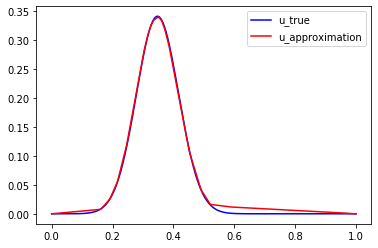

In [30]:
plt.plot(points, yt, color = 'b', label = 'u_true')
plt.plot(points, ymu, color = 'r', label = 'u_approximation')
plt.legend()

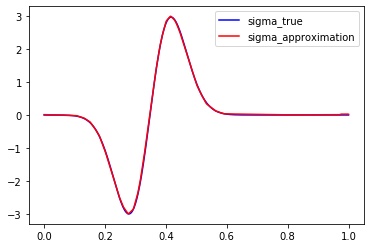

In [31]:
plt.plot(points, y_diff, color = 'b', label = 'sigma_true')
plt.plot(points, ysig, color = 'r', label = 'sigma_approximation')
plt.legend()